# Notebook for analysing and reviewing experiment results

In [6]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
target_file = "output.json"
f = open(target_file)
data = json.load(f)
f.close()



JSONDecodeError: Extra data: line 2 column 1 (char 1165)

In [ ]:
for i in data:
    print(i)

## Testing Prior to Fine Tuning

In [2]:
import model_helper as mh
import data_helper_v2 as dh

model = mh.get_model(ts_encoder_config={"name": 'LSTM'}, text_encoder_config={"name": 'bert-base-uncased', "auto-pre-trained": True},
                      projection_dim=64, ts_window=5)
    
df = dh._helper_generate_synthetic_benchmark(model=model)

df["label"] = df['label'].replace(0, -1)


c:\Users\eoinp\anaconda3\envs\deepl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\eoinp\anaconda3\envs\deepl\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\eoinp\anaconda3\envs\deepl\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from tqdm import tqdm
import numpy as np
df["cosine_similarity"] = None


text_tokenizer = model.get_text_tokenizer()
prior_to_train_dataset = dh.CustomDataset(df, text_tokenizer=text_tokenizer)

dataloader = DataLoader(prior_to_train_dataset, batch_size=32, shuffle=False)
device = 'cpu'
model.eval()

all_preds = []

with torch.no_grad():
    for ts_data, text_data, attention_mask, labels in tqdm(dataloader, leave=True, position=1):
        ts_data = ts_data.to(device)
        text_data = text_data.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        ts_embeddings, text_embeddings = model(ts_data, text_data, attention_mask)



        preds = model.predict(ts_data=ts_data, input_ids=text_data, attention_mask=attention_mask)#TODO same as train loop, check it works with the batch of embeddings
        all_preds.extend(preds)

all_preds = np.array(all_preds) #convert to numpy array
df["cosine_similarity"] = all_preds

df_positives = df.loc[df["label"] == 1]
df_negatives = df.loc[df["label"] == -1]

100%|██████████| 94/94 [01:16<00:00,  1.22it/s]


In [3]:
df_positives

,id,ticker,Start Date,text,time_series,label,cosine_similarity
0,0,APPL,2024-08-14 23:13:20.863736,decline decrease drop negative loss,"[[51], [50], [49], [48], [47]]",1,-0.047213
2,2,APPL,2024-08-12 23:13:20.863736,negative decrease drop loss decline,"[[78], [77], [76], [75], [74]]",1,-0.125635
3,3,APPL,2024-08-11 23:13:20.863736,growth positive gain rise increase,"[[67], [68], [69], [70], [71]]",1,-0.108888
5,5,APPL,2024-08-09 23:13:20.863736,drop decrease decline negative loss,"[[57], [56], [55], [54], [53]]",1,-0.071609
6,6,APPL,2024-08-08 23:13:20.863736,positive gain growth increase rise,"[[75], [76], [77], [78], [79]]",1,-0.102501
...,...,...,...,...,...,...,...
2991,2991,MSFN,2023-04-11 23:13:20.863736,gain growth rise increase positive,"[[82], [83], [84], [85], [86]]",1,-0.101563
2994,2994,MSFN,2023-04-08 23:13:20.863736,decline decrease negative loss drop,"[[97], [96], [95], [94], [93]]",1,-0.081359
2995,2995,MSFN,2023-04-07 23:13:20.863736,rise positive increase growth gain,"[[88], [89], [90], [91], [92]]",1,-0.088990
2996,2996,MSFN,2023-04-06 23:13:20.863736,positive gain growth increase rise,"[[91], [92], [93], [94], [95]]",1,-0.107800


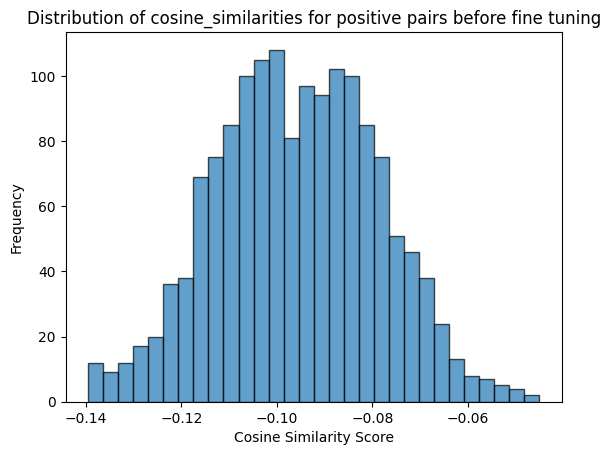

,id,ticker,Start Date,text,time_series,label,cosine_similarity
0,0,APPL,2024-08-14 23:13:20.863736,decline decrease drop negative loss,"[[51], [50], [49], [48], [47]]",1,-0.047213
2,2,APPL,2024-08-12 23:13:20.863736,negative decrease drop loss decline,"[[78], [77], [76], [75], [74]]",1,-0.125635
3,3,APPL,2024-08-11 23:13:20.863736,growth positive gain rise increase,"[[67], [68], [69], [70], [71]]",1,-0.108888
5,5,APPL,2024-08-09 23:13:20.863736,drop decrease decline negative loss,"[[57], [56], [55], [54], [53]]",1,-0.071609
6,6,APPL,2024-08-08 23:13:20.863736,positive gain growth increase rise,"[[75], [76], [77], [78], [79]]",1,-0.102501
...,...,...,...,...,...,...,...
2991,2991,MSFN,2023-04-11 23:13:20.863736,gain growth rise increase positive,"[[82], [83], [84], [85], [86]]",1,-0.101563
2994,2994,MSFN,2023-04-08 23:13:20.863736,decline decrease negative loss drop,"[[97], [96], [95], [94], [93]]",1,-0.081359
2995,2995,MSFN,2023-04-07 23:13:20.863736,rise positive increase growth gain,"[[88], [89], [90], [91], [92]]",1,-0.088990
2996,2996,MSFN,2023-04-06 23:13:20.863736,positive gain growth increase rise,"[[91], [92], [93], [94], [95]]",1,-0.107800


In [4]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'column_name' is the column you want to plot
df_positives['cosine_similarity'].plot(kind='hist', bins=30, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of cosine_similarities for positive pairs before fine tuning')

# Show the plot
plt.show()

df_positives

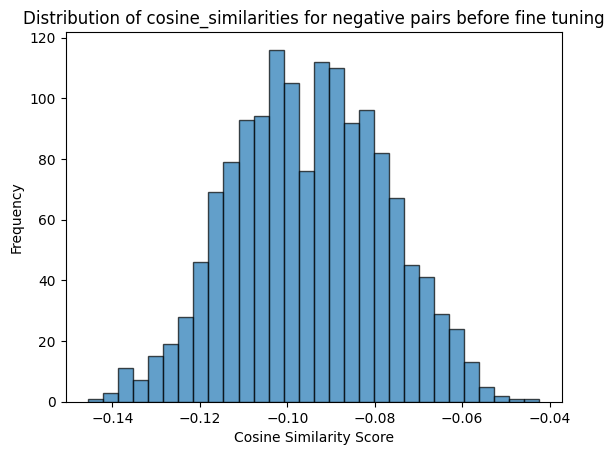

,id,ticker,Start Date,text,time_series,label,cosine_similarity
1,1,APPL,2024-08-13 23:13:20.863736,decline loss decrease negative drop,"[[53], [54], [55], [56], [57]]",-1,-0.088750
4,4,APPL,2024-08-10 23:13:20.863736,loss decrease decline negative drop,"[[76], [77], [78], [79], [80]]",-1,-0.063986
7,7,APPL,2024-08-07 23:13:20.863736,decrease drop negative loss decline,"[[66], [67], [68], [69], [70]]",-1,-0.102987
8,8,APPL,2024-08-06 23:13:20.863736,decline decrease loss negative drop,"[[87], [88], [89], [90], [91]]",-1,-0.074792
9,9,APPL,2024-08-05 23:13:20.863736,gain rise growth increase positive,"[[57], [56], [55], [54], [53]]",-1,-0.079814
...,...,...,...,...,...,...,...
2989,2989,MSFN,2023-04-13 23:13:20.863736,growth increase positive gain rise,"[[67], [66], [65], [64], [63]]",-1,-0.089677
2992,2992,MSFN,2023-04-10 23:13:20.863736,negative loss decline decrease drop,"[[91], [92], [93], [94], [95]]",-1,-0.103863
2993,2993,MSFN,2023-04-09 23:13:20.863736,positive growth increase gain rise,"[[93], [92], [91], [90], [89]]",-1,-0.115689
2997,2997,MSFN,2023-04-05 23:13:20.863736,gain positive increase growth rise,"[[86], [85], [84], [83], [82]]",-1,-0.082992


In [5]:
df_negatives['cosine_similarity'].plot(kind='hist', bins=30, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of cosine_similarities for negative pairs before fine tuning')

# Show the plot
plt.show()
df_negatives

In [42]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CosineEmbeddingLoss(margin=0.0, size_average=None, reduce=None, reduction='mean')
mh.train(model=model, train_loader=dataloader, optimizer=optimizer , device='cpu', criterion=criterion)

100%|██████████| 94/94 [08:48<00:00,  5.62s/it]


(0.5110882961369575,
 0.5086666666666667,
 0.38307414889032537,
 array([[  79, 1403],
        [  71, 1447]], dtype=int64))

In [43]:
#df["cosine_similarity"] = None

model.eval()

after_one_epoch_all_preds = []

with torch.no_grad():
    for ts_data, text_data, attention_mask, labels in tqdm(dataloader, leave=True, position=1):
        ts_data = ts_data.to(device)
        text_data = text_data.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        ts_embeddings, text_embeddings = model(ts_data, text_data, attention_mask)



        preds = model.predict(ts_data=ts_data, input_ids=text_data, attention_mask=attention_mask)#TODO same as train loop, check it works with the batch of embeddings
        after_one_epoch_all_preds.extend(preds)

after_one_epoch_all_preds = np.array(after_one_epoch_all_preds) #convert to numpy array
df["cosine_similarity"] = after_one_epoch_all_preds

after_one_epoch_all_preds_df_positives = df.loc[df["label"] == 1]
after_one_epoch_all_preds_df_negatives = df.loc[df["label"] == -1]

 17%|█▋        | 16/94 [00:22<01:49,  1.40s/it]


KeyboardInterrupt: 

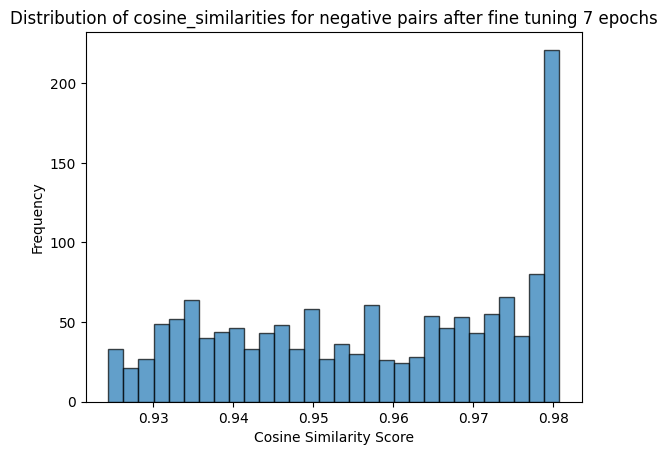

,id,ticker,Start Date,text,time_series,label,cosine_similarity
1,1,APPL,2024-08-13 23:13:20.863736,decline loss decrease negative drop,"[[53], [54], [55], [56], [57]]",-1,0.980636
4,4,APPL,2024-08-10 23:13:20.863736,loss decrease decline negative drop,"[[76], [77], [78], [79], [80]]",-1,0.953558
7,7,APPL,2024-08-07 23:13:20.863736,decrease drop negative loss decline,"[[66], [67], [68], [69], [70]]",-1,0.969306
8,8,APPL,2024-08-06 23:13:20.863736,decline decrease loss negative drop,"[[87], [88], [89], [90], [91]]",-1,0.938658
9,9,APPL,2024-08-05 23:13:20.863736,gain rise growth increase positive,"[[57], [56], [55], [54], [53]]",-1,0.979164
...,...,...,...,...,...,...,...
2989,2989,MSFN,2023-04-13 23:13:20.863736,growth increase positive gain rise,"[[67], [66], [65], [64], [63]]",-1,0.975608
2992,2992,MSFN,2023-04-10 23:13:20.863736,negative loss decline decrease drop,"[[91], [92], [93], [94], [95]]",-1,0.933957
2993,2993,MSFN,2023-04-09 23:13:20.863736,positive growth increase gain rise,"[[93], [92], [91], [90], [89]]",-1,0.938822
2997,2997,MSFN,2023-04-05 23:13:20.863736,gain positive increase growth rise,"[[86], [85], [84], [83], [82]]",-1,0.947751


In [ ]:
after_one_epoch_all_preds_df_negatives['cosine_similarity'].plot(kind='hist', bins=30, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of cosine_similarities for negative pairs after fine tuning 8 epochs')

# Show the plot
plt.show()
after_one_epoch_all_preds_df_negatives

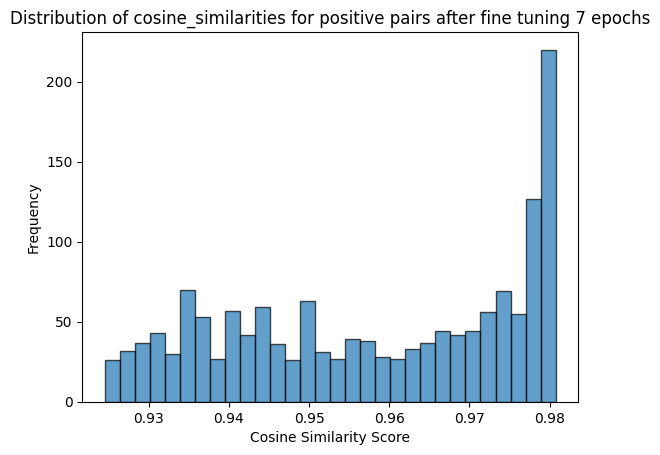

,id,ticker,Start Date,text,time_series,label,cosine_similarity
0,0,APPL,2024-08-14 23:13:20.863736,decline decrease drop negative loss,"[[51], [50], [49], [48], [47]]",1,0.969699
2,2,APPL,2024-08-12 23:13:20.863736,negative decrease drop loss decline,"[[78], [77], [76], [75], [74]]",1,0.959337
3,3,APPL,2024-08-11 23:13:20.863736,growth positive gain rise increase,"[[67], [68], [69], [70], [71]]",1,0.967799
5,5,APPL,2024-08-09 23:13:20.863736,drop decrease decline negative loss,"[[57], [56], [55], [54], [53]]",1,0.979208
6,6,APPL,2024-08-08 23:13:20.863736,positive gain growth increase rise,"[[75], [76], [77], [78], [79]]",1,0.955159
...,...,...,...,...,...,...,...
2991,2991,MSFN,2023-04-11 23:13:20.863736,gain growth rise increase positive,"[[82], [83], [84], [85], [86]]",1,0.945139
2994,2994,MSFN,2023-04-08 23:13:20.863736,decline decrease negative loss drop,"[[97], [96], [95], [94], [93]]",1,0.934047
2995,2995,MSFN,2023-04-07 23:13:20.863736,rise positive increase growth gain,"[[88], [89], [90], [91], [92]]",1,0.937572
2996,2996,MSFN,2023-04-06 23:13:20.863736,positive gain growth increase rise,"[[91], [92], [93], [94], [95]]",1,0.934083


In [ ]:
after_one_epoch_all_preds_df_positives['cosine_similarity'].plot(kind='hist', bins=30, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of cosine_similarities for positive pairs after fine tuning 8 epochs')

# Show the plot
plt.show()
after_one_epoch_all_preds_df_positives

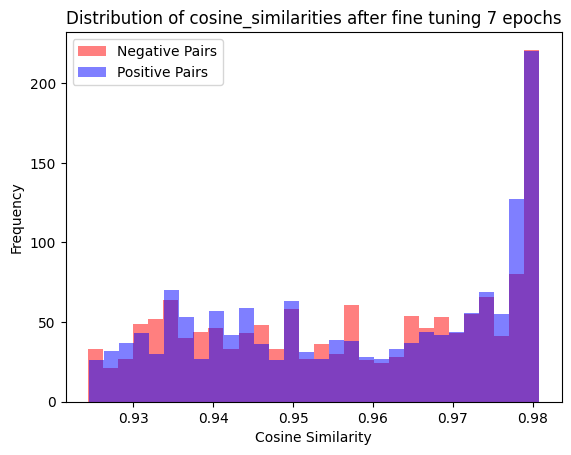

In [ ]:
df[df['label'] == -1]['cosine_similarity'].plot(kind='hist', bins=30, alpha=0.5, color='red', label='Negative Pairs')

# Histogram for category 1
df[df['label'] == 1]['cosine_similarity'].plot(kind='hist', bins=30, alpha=0.5, color='blue', label='Positive Pairs')

# Adding labels and legend
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of cosine_similarities after fine tuning 8 epochs')
plt.legend()

# Show the plot
plt.show()

In [3]:
import data_helper_v2 as dh
import model_helper as mh
model = mh.get_model(ts_encoder_config={"name": 'TSTransformerBaseEncoder'}, text_encoder_config={"name": 'bert-base-uncased', "auto-pre-trained": True}, projection_dim=500, ts_window=5)
stock_emotions_df = dh.get_data("stock_emotions", model=model)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [4]:
stock_emotions_df

,id,ticker,text,start_date,time_series,all_dates,label,past_time_features
0,100028,AAPL,Apple it’s just too funny and easy to laugh at...,2020-01-06,"[[74.94999694824219], [74.59750366210938], [75...",3 2020-01-06 4 2020-01-07 5 2020-01-08 6...,1,"[[1, 6], [1, 7], [1, 8], [1, 9], [1, 10]]"
1,100205,AAPL,Apple I guess it’s time to readjust my screen ...,2020-01-16,"[[78.80999755859375], [79.68250274658203], [79...",11 2020-01-16 12 2020-01-17 13 2020-01-2...,1,"[[1, 16], [1, 17], [1, 21], [1, 22], [1, 23]]"
2,100240,AAPL,Apple bulls believing every day green [grinni...,2020-01-21,"[[79.14250183105469], [79.42500305175781], [79...",13 2020-01-21 14 2020-01-22 15 2020-01-2...,1,"[[1, 21], [1, 22], [1, 23], [1, 24], [1, 27]]"
3,100315,AAPL,Apple These going to PAY BIGLY tomorrow [grim...,2020-01-27,"[[77.23750305175781], [79.42250061035156], [81...",17 2020-01-27 18 2020-01-28 19 2020-01-2...,1,"[[1, 27], [1, 28], [1, 29], [1, 30], [1, 31]]"
4,100441,AAPL,Apple Bulls believing the Corona virus [micro...,2020-01-31,"[[77.37750244140625], [77.16500091552734], [79...",21 2020-01-31 22 2020-02-03 23 2020-02-0...,1,"[[1, 31], [2, 3], [2, 4], [2, 5], [2, 6]]"
...,...,...,...,...,...,...,...,...
1869,106259,XOM,"Exxon Mobil sold it at 34.8 , I’m feeling smar...",2020-09-30,"[[76.0], [77.87000274658203], [75.870002746582...",189 2020-09-30 190 2020-10-01 191 2020-1...,0,"[[9, 30], [10, 1], [10, 2], [10, 5], [10, 6]]"
1870,106417,XOM,Exxon Mobil I [eyes] a crossover forming on ...,2020-10-08,"[[116.88999938964844], [117.08000183105467], [...",195 2020-10-08 196 2020-10-09 197 2020-1...,0,"[[10, 8], [10, 9], [10, 12], [10, 13], [10, 14]]"
1871,106651,XOM,Exxon Mobil dividend cut is coming ? [confoun...,2020-10-22,"[[165.6999969482422], [166.72000122070312], [1...",205 2020-10-22 206 2020-10-23 207 2020-1...,0,"[[10, 22], [10, 23], [10, 26], [10, 27], [10, ..."
1872,106734,XOM,Exxon Mobil must be one of the ugliest charts ...,2020-10-29,"[[98.35749816894533], [97.0], [97.272499084472...",210 2020-10-29 211 2020-10-30 212 2020-1...,0,"[[10, 29], [10, 30], [11, 2], [11, 3], [11, 4]]"


In [6]:
stock_emotions_df.iloc[0]["text"]

"Apple it’s just too funny and easy to laugh at bears at this point. Why don’t you guys do something useful like find a good job so you can afford to buy Apple instead of just posting jealous hate and looking like a  [clown face] Apple once hits 300 today, needs another 100 points to reach 400 like that smart gentleman said on CNBC this am  [thumbs up medium skin tone]  Apple Bears & Shorts Later Today  [face with tears of joy] Apple who is ready to open tomorrow  at $290. It’s time  [pig face] Apple Green by morning my ass!! Y’all should have taken profits  [face with tears of joy]  [man facepalming light skin tone]  [eyes]  [red apple] Apple buy 300 call easy money  [rolling on the floor laughing] Apple maybe dan Ives at Wedbush can reimburse all you chasers for your losses. Or maybe not  [face with tears of joy] Apple short term  [bear]  people need to pull some off the table with all uncertainty floating around. This is just dicey Apple What makes bulls believe that Terrorist will 

In [7]:
stock_emotions_df.iloc[0]["time_series"]

[[74.94999694824219],
 [74.59750366210938],
 [75.79750061035156],
 [77.40750122070312],
 [77.5824966430664]]

In [9]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel

# Step 1: Load the configuration and model
config = TimeSeriesTransformerConfig(prediction_length=12, lags_sequence=[1, 2, 3])
model = TimeSeriesTransformerModel(config)

def ids_tensor(shape, vocab_size):
    return torch.randint(low=0, high=vocab_size, size=shape)

# Step 2: Pass your input time series data to the model
# Assuming input_data is your tensor with shape [batch_size, sequence_length, num_features]
# input_data should be a PyTorch tensor
import torch

# Example dimensions
batch_size = 32
sequence_length = 50
num_features = 4

inputs = dict()
context_length = 5
batch_size = 2
cardinality = 5
num_time_features = 10
content_length = 8
prediction_length = 2
lags_sequence = [2, 3]
past_length = context_length + max(lags_sequence)

# encoder inputs
#inputs["static_categorical_features"] = ids_tensor([batch_size, 1], cardinality)
inputs["static_real_features"] = torch.randn([batch_size, 1])
inputs["past_time_features"] = torch.randn([batch_size, past_length, num_time_features])
inputs["past_values"] = torch.randn([batch_size, past_length])
inputs["past_observed_mask"] = torch.ones([batch_size, past_length])

# decoder inputs
inputs["future_time_features"] = torch.randn([batch_size, prediction_length, num_time_features])
inputs["future_values"] = torch.randn([batch_size, prediction_length])

outputs = model(**inputs)

# Step 4: Extract the embeddings
embeddings = outputs.last_hidden_state  # Shape: [batch_size, sequence_length, hidden_size]

# embeddings now contains the output from the last hidden layer, which you can use as desired.


ValueError: lags cannot go further than history length, found lag 12 while history length is only 10

In [43]:
from huggingface_hub import hf_hub_download
import torch
from transformers import TimeSeriesTransformerModel

file = hf_hub_download(
    repo_id="hf-internal-testing/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
)
batch = torch.load(file)

model = TimeSeriesTransformerModel.from_pretrained("huggingface/time-series-transformer-tourism-monthly")

# during training, one provides both past and future values
# as well as possible additional features
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
)

last_hidden_state = outputs.last_hidden_state
model.config

TimeSeriesTransformerConfig {
  "_name_or_path": "huggingface/time-series-transformer-tourism-monthly",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "architectures": [
    "TimeSeriesTransformerForPrediction"
  ],
  "attention_dropout": 0.1,
  "cardinality": [
    366
  ],
  "context_length": 24,
  "d_model": 26,
  "decoder_attention_heads": 2,
  "decoder_ffn_dim": 32,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 2,
  "distribution_output": "student_t",
  "dropout": 0.1,
  "embedding_dimension": [
    6
  ],
  "encoder_attention_heads": 2,
  "encoder_ffn_dim": 32,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 2,
  "feature_size": 27,
  "init_std": 0.02,
  "input_size": 1,
  "is_encoder_decoder": true,
  "lags_sequence": [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    11,
    12,
    13,
    23,
    24,
    25,
    35,
    36,
    37
  ],
  "loss": "nll",
  "model_type": "time_series_transformer",
  "num_dynamic_real_features": 0,
  "num_parallel_samples":

In [72]:
from huggingface_hub import hf_hub_download
import torch
from transformers import TimeSeriesTransformerModel

file = hf_hub_download(
    repo_id="hf-internal-testing/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
)
batch = torch.load(file)

model = TimeSeriesTransformerModel.from_pretrained("ibm-granite/granite-timeseries-ttm-v1")

#print(model.config)
#config.lags_sequence = [
#    1,
#    2,
#    3,
#    4,
#    5,
#    6,
#    7,
#    11,
#    12,
#    13,
#    23,
#    24,
#    25,
#    35,
#    36,
#    37
#  ]
## during training, one provides both past and future values
# as well as possible additional features
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    #static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    #future_values=batch["future_values"],
    #future_time_features=batch["future_time_features"],
)

last_hidden_state = outputs.last_hidden_state

You are using a model of type tinytimemixer to instantiate a model of type time_series_transformer. This is not supported for all configurations of models and can yield errors.
Some weights of TimeSeriesTransformerModel were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-v1 and are newly initialized: ['decoder.embed_positions.weight', 'decoder.layernorm_embedding.bias', 'decoder.layernorm_embedding.weight', 'decoder.layers.0.encoder_attn.k_proj.bias', 'decoder.layers.0.encoder_attn.k_proj.weight', 'decoder.layers.0.encoder_attn.out_proj.bias', 'decoder.layers.0.encoder_attn.out_proj.weight', 'decoder.layers.0.encoder_attn.q_proj.bias', 'decoder.layers.0.encoder_attn.q_proj.weight', 'decoder.layers.0.encoder_attn.v_proj.bias', 'decoder.layers.0.encoder_attn.v_proj.weight', 'decoder.layers.0.encoder_attn_layer_norm.bias', 'decoder.layers.0.encoder_attn_layer_norm.weight', 'decoder.layers.0.fc1.bias', 'decoder.layers.0.fc1.weight', 'decoder.layers.0.fc2.bi

ValueError: lags cannot go further than history length, found lag 7 while history length is only 61

In [73]:
for key in batch.keys():

    print(key)
    print(batch[key].shape)

static_categorical_features
torch.Size([64, 1])
static_real_features
torch.Size([64, 1])
past_time_features
torch.Size([64, 61, 2])
past_values
torch.Size([64, 61])
past_observed_mask
torch.Size([64, 61])
future_time_features
torch.Size([64, 24, 2])
future_values
torch.Size([64, 24])
future_observed_mask
torch.Size([64, 24])


In [77]:
batch['past_time_features']

tensor([[[ 0.1364,  2.2175],
         [ 0.2273,  2.2201],
         [ 0.3182,  2.2227],
         ...,
         [-0.0455,  2.3483],
         [ 0.0455,  2.3502],
         [ 0.1364,  2.3522]],

        [[ 0.1364,  2.1847],
         [ 0.2273,  2.1875],
         [ 0.3182,  2.1903],
         ...,
         [-0.0455,  2.3243],
         [ 0.0455,  2.3263],
         [ 0.1364,  2.3284]],

        [[ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [-0.2273,  0.6990],
         [-0.1364,  0.7782],
         [-0.0455,  0.8451]],

        ...,

        [[ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [ 0.4091,  1.5563],
         [ 0.5000,  1.5682],
         [-0.5000,  1.5798]],

        [[-0.4091,  1.7993],
         [-0.3182,  1.8062],
         [-0.2273,  1.8129],
         ...,
         [ 0.5000,  2.0828],
         [-0.5000,  2.0864],
         [-0.4091,  2.0899]],

        [[ 0.5000,  1.1139],
       

In [26]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel

# Initializing a default Time Series Transformer configuration
configuration = TimeSeriesTransformerConfig(prediction_length=10)

# Randomly initializing a model from the configuration
model = TimeSeriesTransformerModel(configuration)

# Accessing the model configuration
configuration = model.config

In [28]:
from transformers import AutoformerConfig, AutoformerModel

# Initializing a default Autoformer configuration
configuration = AutoformerConfig(prediction_length=10)

# Randomly initializing a model (with random weights) from the configuration
model = AutoformerModel(configuration)

# Accessing the model configuration
configuration = model.config

ValueError: The `prediction_length` config needs to be specified.

In [38]:
# Load Model from HF Model Hub mentioning the branch name in revision field

model = TinyTimeMixerForPrediction.from_pretrained(
                "https://huggingface.co/ibm/TTM", revision="main"
            ) 

# Do zeroshot
zeroshot_trainer = Trainer(
        model=model,
        args=zeroshot_forecast_args,
        )
    

zeroshot_output = zeroshot_trainer.evaluate(dset_test)


# Freeze backbone and enable few-shot or finetuning:

# freeze backbone
for param in model.backbone.parameters():
  param.requires_grad = False

finetune_forecast_trainer = Trainer(
        model=model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
finetune_forecast_trainer.train()
fewshot_output = finetune_forecast_trainer.evaluate(dset_test)


IndentationError: unexpected indent (744923598.py, line 12)

In [10]:
from datasets import load_dataset

dataset = load_dataset("monash_tsf", "tourism_monthly")


c:\Users\eoinp\anaconda3\envs\deepl\Lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for monash_tsf contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/monash_tsf
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating validation split: 100%|██████████| 366/366 [00:00<00:00, 1270.80 examples/s]


In [27]:
dataset
train_example = dataset['train'][0]
print(train_example.keys())
print(train_example['start'])
print(train_example['target'])
print(train_example['feat_static_cat'])
print(train_example['feat_dynamic_real'])
print(train_example['item_id'])



dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])
1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.97497

In [41]:


# Load the IBM Granite model
model = TimeSeriesTransformerModel.from_pretrained("ibm-granite/granite-timeseries-ttm-v1")

import torch

# Assuming you have the time series data
batch_size = 10
sequence_length = 50
feature_dim = 20

# Example time series data with shape (batch_size, sequence_length, feature_dim)
time_series_data = torch.rand((batch_size, sequence_length, feature_dim)).float()

# Generating past_time_features, could be similar to time_series_data or additional features
num_additional_features = 5  # Number of additional time-related features
past_time_features = torch.rand((batch_size, sequence_length, num_additional_features)).float()

# Generating past_observed_mask, a binary mask indicating observed time steps
# Assuming all time steps are observed in this example
past_observed_mask = torch.ones((batch_size, sequence_length)).float()

# Now you can pass these to the model
outputs = model(time_series_data, past_time_features, past_observed_mask)

# Get the last hidden state
last_hidden_state = outputs.last_hidden_state


You are using a model of type tinytimemixer to instantiate a model of type time_series_transformer. This is not supported for all configurations of models and can yield errors.
Some weights of TimeSeriesTransformerModel were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-v1 and are newly initialized: ['decoder.embed_positions.weight', 'decoder.layernorm_embedding.bias', 'decoder.layernorm_embedding.weight', 'decoder.layers.0.encoder_attn.k_proj.bias', 'decoder.layers.0.encoder_attn.k_proj.weight', 'decoder.layers.0.encoder_attn.out_proj.bias', 'decoder.layers.0.encoder_attn.out_proj.weight', 'decoder.layers.0.encoder_attn.q_proj.bias', 'decoder.layers.0.encoder_attn.q_proj.weight', 'decoder.layers.0.encoder_attn.v_proj.bias', 'decoder.layers.0.encoder_attn.v_proj.weight', 'decoder.layers.0.encoder_attn_layer_norm.bias', 'decoder.layers.0.encoder_attn_layer_norm.weight', 'decoder.layers.0.fc1.bias', 'decoder.layers.0.fc1.weight', 'decoder.layers.0.fc2.bi

RuntimeError: The size of tensor a (20) must match the size of tensor b (50) at non-singleton dimension 2

In [51]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-31,72.482498,73.419998,72.379997,73.412498,71.520821,100805600
1,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.152649,135480400
2,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.441460,146322800
3,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.018677,118387200
4,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.675278,108872000
...,...,...,...,...,...,...,...
249,2020-12-24,131.320007,133.460007,131.100006,131.970001,129.679718,54930100
250,2020-12-28,133.990005,137.339996,133.509995,136.690002,134.317825,124486200
251,2020-12-29,138.050003,138.789993,134.339996,134.869995,132.529404,121047300
252,2020-12-30,135.580002,135.990005,133.399994,133.720001,131.399368,96452100


In [52]:
import pandas as pd
import torch

# Load the CSV file
file_path = './data/stock_emotions/price/AAPL.csv'
df = pd.read_csv(file_path)

# Select a single row to predict from (assuming row 10)
row_idx = 10

# Define past and future horizons
past_horizon = 5
future_horizon = 3

# Extract past values
past_values = df['Close'].iloc[row_idx-past_horizon:row_idx].values
past_values = torch.tensor(past_values, dtype=torch.float32)

# Extract past time features (e.g., day of the week)
past_time_features = pd.to_datetime(df['Date'].iloc[row_idx-past_horizon:row_idx])
past_time_features = torch.tensor(past_time_features.dt.dayofweek.values, dtype=torch.float32)

# Generate a binary observed mask (assume all values are observed in this example)
past_observed_mask = torch.ones(past_horizon, dtype=torch.float32)

# Assuming no static features for this example
static_real_features = torch.tensor([], dtype=torch.float32)

# Extract future values (target values)
future_values = df['Close'].iloc[row_idx:row_idx+future_horizon].values
future_values = torch.tensor(future_values, dtype=torch.float32)

# Extract future time features
future_time_features = pd.to_datetime(df['Date'].iloc[row_idx:row_idx+future_horizon])
future_time_features = torch.tensor(future_time_features.dt.dayofweek.values, dtype=torch.float32)

# Print out the variables
print("past_values:", past_values)
print("past_time_features:", past_time_features)
print("past_observed_mask:", past_observed_mask)
print("static_real_features:", static_real_features)
print("future_values:", future_values)
print("future_time_features:", future_time_features)



past_values: tensor([75.7975, 77.4075, 77.5825, 79.2400, 78.1700])
past_time_features: tensor([2., 3., 4., 0., 1.])
past_observed_mask: tensor([1., 1., 1., 1., 1.])
static_real_features: tensor([])
future_values: tensor([77.8350, 78.8100, 79.6825])
future_time_features: tensor([2., 3., 4.])


In [63]:
from transformers import TimeSeriesTransformerModel

# Load the pre-trained model
model = TimeSeriesTransformerModel.from_pretrained('ibm-granite/granite-timeseries-ttm-v1')

# Set the model to evaluation mode
model.eval()

# Example data from earlier steps
past_values = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0]).unsqueeze(0)  # Shape: [batch_size, past_horizon]
past_time_features = torch.tensor([0, 1, 2, 3, 4]).unsqueeze(0)     # Shape: [batch_size, past_horizon, num_features]
past_observed_mask = torch.tensor([1, 1, 1, 1, 1]).unsqueeze(0)     # Shape: [batch_size, past_horizon]
static_real_features =  torch.empty((batch_size, 1, 0)).float().unsqueeze(0)                # Shape: [batch_size, num_static_features]
future_values = torch.tensor([6.0, 7.0, 8.0]).unsqueeze(0)          # Shape: [batch_size, future_horizon]
future_time_features = torch.tensor([5, 6, 0]).unsqueeze(0)         # Shape: [batch_size, future_horizon, num_features]


You are using a model of type tinytimemixer to instantiate a model of type time_series_transformer. This is not supported for all configurations of models and can yield errors.
Some weights of TimeSeriesTransformerModel were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-v1 and are newly initialized: ['decoder.embed_positions.weight', 'decoder.layernorm_embedding.bias', 'decoder.layernorm_embedding.weight', 'decoder.layers.0.encoder_attn.k_proj.bias', 'decoder.layers.0.encoder_attn.k_proj.weight', 'decoder.layers.0.encoder_attn.out_proj.bias', 'decoder.layers.0.encoder_attn.out_proj.weight', 'decoder.layers.0.encoder_attn.q_proj.bias', 'decoder.layers.0.encoder_attn.q_proj.weight', 'decoder.layers.0.encoder_attn.v_proj.bias', 'decoder.layers.0.encoder_attn.v_proj.weight', 'decoder.layers.0.encoder_attn_layer_norm.bias', 'decoder.layers.0.encoder_attn_layer_norm.weight', 'decoder.layers.0.fc1.bias', 'decoder.layers.0.fc1.weight', 'decoder.layers.0.fc2.bi

In [65]:
# Pass the inputs through the model
outputs = model(
    past_values=past_values,
    past_time_features=past_time_features,
    past_observed_mask=past_observed_mask,
    static_real_features=static_real_features,
    future_values=future_values,
    future_time_features=future_time_features,
)

# Extract the last hidden state from the model's output
last_hidden_state = outputs.last_hidden_state

# Print the last hidden state
print("Last Hidden State:", last_hidden_state)


RuntimeError: Tensors must have same number of dimensions: got 4 and 2

In [67]:
batch

{'static_categorical_features': tensor([[29],
         [31],
         [32],
         [32],
         [32],
         [33],
         [33],
         [34],
         [34],
         [35],
         [37],
         [39],
         [44],
         [46],
         [47],
         [47],
         [49],
         [50],
         [50],
         [51],
         [52],
         [53],
         [53],
         [54],
         [54],
         [56],
         [56],
         [59],
         [60],
         [62],
         [63],
         [66],
         [67],
         [67],
         [68],
         [70],
         [70],
         [71],
         [72],
         [73],
         [75],
         [76],
         [76],
         [77],
         [77],
         [78],
         [78],
         [79],
         [80],
         [81],
         [82],
         [83],
         [83],
         [84],
         [84],
         [85],
         [86],
         [86],
         [86],
         [87],
         [88],
         [90],
         [92],
         [93]]),
 'stati

In [68]:
import torch
from transformers import TimeSeriesTransformerModel

# Load the pre-trained model
model = TimeSeriesTransformerModel.from_pretrained('ibm-granite/granite-timeseries-ttm-v1')
model.eval()

# Example data from earlier steps (modify as needed for your data)
batch_size = 1
past_values = torch.tensor([[1.0, 2.0, 3.0, 4.0, 5.0]])  # Shape: [batch_size, past_horizon]
past_time_features = torch.tensor([[0, 1, 2, 3, 4]])     # Shape: [batch_size, past_horizon, num_features]
past_observed_mask = torch.tensor([[1, 1, 1, 1, 1]])     # Shape: [batch_size, past_horizon]

# If no static features, create an empty tensor with the correct shape
static_real_features = torch.empty((batch_size, 0)).float()  # Shape: [batch_size, 1, 0]

future_values = torch.tensor([[6.0, 7.0, 8.0]])  # Shape: [batch_size, future_horizon]
future_time_features = torch.tensor([[5, 6, 0]])  # Shape: [batch_size, future_horizon, num_features]

# Pass the inputs through the model
outputs = model(
    past_values=past_values,
    past_time_features=past_time_features,
    past_observed_mask=past_observed_mask,
    static_real_features=static_real_features,  # Pass an empty tensor here
    future_values=future_values,
    future_time_features=future_time_features,
)

# Extract the last hidden state from the model's output
last_hidden_state = outputs.last_hidden_state

# Print the last hidden state
print("Last Hidden State:", last_hidden_state)


You are using a model of type tinytimemixer to instantiate a model of type time_series_transformer. This is not supported for all configurations of models and can yield errors.
Some weights of TimeSeriesTransformerModel were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-v1 and are newly initialized: ['decoder.embed_positions.weight', 'decoder.layernorm_embedding.bias', 'decoder.layernorm_embedding.weight', 'decoder.layers.0.encoder_attn.k_proj.bias', 'decoder.layers.0.encoder_attn.k_proj.weight', 'decoder.layers.0.encoder_attn.out_proj.bias', 'decoder.layers.0.encoder_attn.out_proj.weight', 'decoder.layers.0.encoder_attn.q_proj.bias', 'decoder.layers.0.encoder_attn.q_proj.weight', 'decoder.layers.0.encoder_attn.v_proj.bias', 'decoder.layers.0.encoder_attn.v_proj.weight', 'decoder.layers.0.encoder_attn_layer_norm.bias', 'decoder.layers.0.encoder_attn_layer_norm.weight', 'decoder.layers.0.fc1.bias', 'decoder.layers.0.fc1.weight', 'decoder.layers.0.fc2.bi

RuntimeError: Tensors must have same number of dimensions: got 3 and 2

In [80]:
from datasets import load_dataset

dataset = load_dataset("monash_tsf", "tourism_monthly")


Using the latest cached version of the module from C:\Users\eoinp\.cache\huggingface\modules\datasets_modules\datasets\monash_tsf\fc869f3ae1577c9def2a919ab1dd0c3d4a7a44826b8e0e8fa423bb0161b629e2 (last modified on Sat Aug 17 09:14:11 2024) since it couldn't be found locally at monash_tsf, or remotely on the Hugging Face Hub.


In [84]:
train_example = dataset['train'][0]
train_example["start"]
validation_example = dataset['validation'][0]
validation_example.keys()


dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [86]:
freq = "1M"
prediction_length = 24

assert len(train_example["target"]) + prediction_length == len(
    validation_example["target"]
)
train_dataset = dataset["train"]
test_dataset = dataset["test"]


In [87]:
from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch


In [88]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))


In [94]:
train_dataset[3]["target"]

[7611.0,
 6859.0,
 9247.0,
 10924.0,
 9064.0,
 7417.0,
 10467.0,
 7921.0,
 8235.0,
 12978.0,
 11397.0,
 11425.0,
 9340.0,
 8487.0,
 11359.0,
 10291.0,
 9239.0,
 8106.0,
 10171.0,
 8871.0,
 8987.0,
 15119.0,
 14205.0,
 13561.0,
 12391.0,
 11800.0,
 13638.0,
 11471.0,
 12288.0,
 10817.0,
 13015.0,
 10553.0,
 10932.0,
 17869.0,
 16805.0,
 14822.0,
 14140.0,
 12626.0,
 16191.0,
 14237.0,
 12823.0,
 10632.0,
 12924.0,
 10015.0,
 10849.0,
 18510.0,
 17769.0,
 15308.0,
 14783.0,
 11863.0,
 17376.0,
 13007.0,
 12380.0,
 9094.0,
 10214.0,
 7818.0,
 8683.0,
 14401.0,
 15375.0,
 15515.0,
 12764.0,
 12913.0,
 15718.0,
 12470.0,
 12089.0,
 10177.0,
 11939.0,
 9677.0,
 9288.0,
 15847.0,
 15766.0,
 17047.0,
 13725.0,
 10226.0,
 13492.0,
 12196.0,
 12027.0,
 11208.0,
 13302.0,
 10554.0,
 10411.0,
 17860.0,
 17660.0,
 19123.0,
 16667.0,
 13534.0,
 16584.0,
 14493.0,
 13732.0,
 11641.0,
 14468.0,
 11760.0,
 11576.0,
 18495.0,
 18417.0,
 18864.0,
 15338.0,
 15066.0,
 16743.0,
 15040.0,
 14920.0,
 12256.0

In [ ]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)



In [95]:
!pip install -q gluonts ujson

ERROR: Could not find a version that satisfies the requirement gluonts (from versions: none)
ERROR: No matching distribution found for gluonts


In [ ]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)



In [6]:
import torch
import torch.nn as nn
from transformers import TimeSeriesTransformerModel, TimeSeriesTransformerConfig
k = 5 #number of inputs
lags_sequence=[1, 2, 3]
context_length=2
#context_lag = 
num_features = 2
config = TimeSeriesTransformerConfig(
    prediction_length=0,  
    context_length=context_length,
    #decoder_attention_heads=1,
    #encoder_attention_heads=1,
    #d_model=74,
    lags_sequence=lags_sequence,
    feature_size=len(lags_sequence) + num_features + 2
)

#Notes:
"""
- Length of k in the below torch tensors need to be size: context_length + max(lags_sequence)
- Not sure what feature_size is actually representing here but I force it to the same size as mat1 dim 2 currently (errors otherwise)
- No idea why last_hidden_state is an empty tensor currently...
- Currently assuming encoder_last_hidden_state is what I want to use as it is the TS embeddings w/o prediction
- mat1 dim 2 effective change seems to be changing lags_sequence (seems to be addition of this) 
- mat 1 dim 2 also effected by past_time_features num_features (third dim) (concatenation of len(lags_sequence), num_features of past_time_features and something else)
- unaccounted for about 2 of mat1 dim 2
"""
model = TimeSeriesTransformerModel(config)

import data_helper_v2 as dh

df = dh.get_data(data_source="stock_emotions", text_window=k)


past_values = torch.tensor([[x[0] for x in df.iloc[0]["time_series"]]])  #torch.rand(32, k)  
past_observed_mask = torch.ones(1, k)
past_time_features = torch.tensor([df.iloc[0]["past_time_features"]])  #torch.rand(32, k, num_features) 

encoder_outputs = model(past_values = past_values, past_observed_mask=past_observed_mask, past_time_features=past_time_features)

last_hidden_state = encoder_outputs.encoder_last_hidden_state

AttributeError: 'NoneType' object has no attribute 'get_text_tokenizer'

In [27]:
past_values

tensor([[74.9500, 74.5975, 75.7975, 77.4075, 77.5825]])

In [8]:
torch.rand(1, k)

tensor([[0.0151, 0.3117, 0.9731, 0.0984, 0.4636, 0.7775, 0.7680]])

In [21]:
[x[0] for x in df.iloc[0]["time_series"]]

[75.79750061035156,
 77.40750122070312,
 77.5824966430664,
 79.23999786376953,
 78.16999816894531]

In [1]:
import data_helper_v2 as dh
import model_helper as mh

model = mh.get_model(ts_encoder_config={"name": 'TSTransformerBaseEncoder'}, text_encoder_config={"name": 'bert-base-uncased', "auto-pre-trained": True})

df = dh.get_data(data_source="stock_emotions")

c:\Users\eoinp\anaconda3\envs\deepl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
past_time_features = []

for idx, row in df.iterrows():
    past_time_features_this_row = []

    for i in row["all_dates"]:
        past_time_features_this_row.append([i.month, i.day])
    past_time_features.append(past_time_features_this_row)

df["past_time_features"] = past_time_features

In [3]:
df.iloc[0]["time_series"]

[[74.94999694824219],
 [74.59750366210938],
 [75.79750061035156],
 [77.40750122070312],
 [77.5824966430664]]

In [1]:
import data_helper_v2 as dh
import model_helper as mh

k = 5
model = mh.get_model(ts_encoder_config={"name": 'TSTransformerBaseEncoder'}, text_encoder_config={"name": 'bert-base-uncased', "auto-pre-trained": True}, ts_window=k, projection_dim=64)

train_dl, val_dl, test_dl = dh.get_data(data_source="stock_emotions", text_window=k, model=model)

c:\Users\eoinp\anaconda3\envs\deepl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please

In [12]:
preds = mh.cosine_similarity_custom(output[0].detach().numpy(), output[1].detach().numpy())

all_preds = (preds >= 0.5).astype(int).tolist()

In [1]:
import json
import matplotlib.pyplot as plt

file_path = 'output.json'  # Make sure to use the correct path

with open(file_path, 'r') as f:
    data = json.load(f)


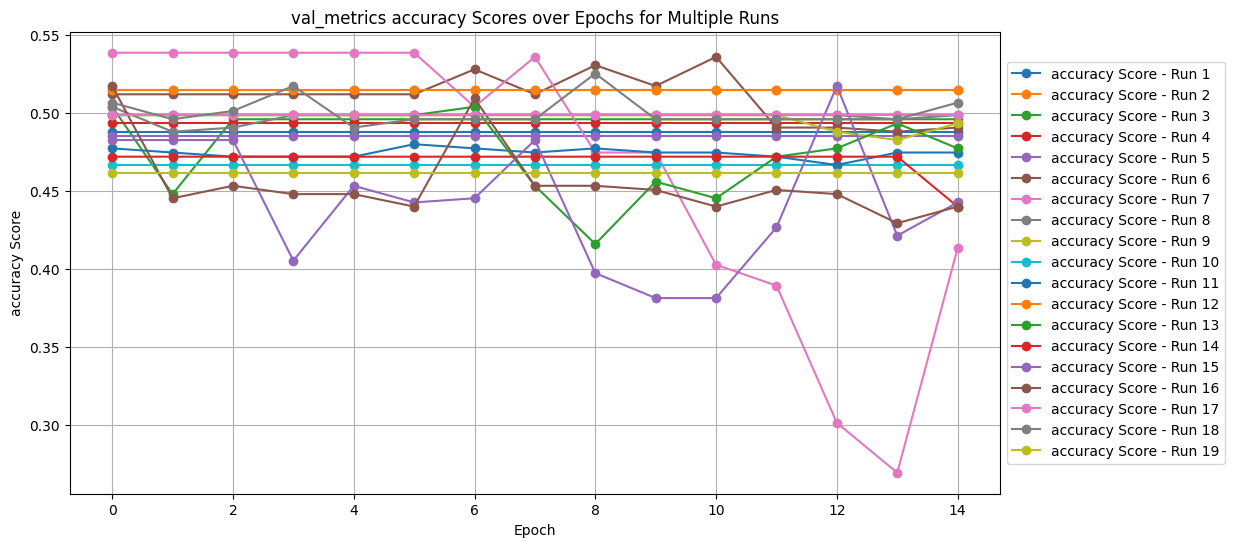

In [16]:
f1_scores = []
epochs = []

plot_value ='accuracy'
metrics_pool = 'val_metrics'
for entry in data:
    epochs.append(entry['epoch'])
    f1_scores.append(entry[metrics_pool][plot_value])

# Step 3: Plot all F1 scores on the same graph
plt.figure(figsize=(12, 6))

# Plot each set of F1 scores
for i, f1 in enumerate(f1_scores):
    plt.plot(epochs[i], f1, marker='o', label=f'{plot_value} Score - Run {i+1}')

plt.title(f'{metrics_pool} {plot_value} Scores over Epochs for Multiple Runs')
plt.xlabel('Epoch')
plt.ylabel(f'{plot_value} Score')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import data_helper_v3 as dh3
data_config = {
    "name": "stock_net",
    "text_path": "./data/stocknet-dataset/tweet/organised_tweet.csv",
    "ts_path": "./data/stocknet-dataset/price/raw/",
    "ts_date_col": 'Date',
    'text_date_col': 'created_at'
}
df = dh3.get_data(data_source=data_config, model=None, text_window=3, loaders=False)

c:\Users\eoinp\anaconda3\envs\deepl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping window for ticker D on 2015-08-14: empty vocabulary; perhaps the documents only contain stop words


In [3]:
import model_helper as mh

model = mh.get_model(ts_encoder_config={"name":"TimeSeriesTransformerModel", "k":5, "context_length": 2, "prediction_length": 0, "lags_sequence":[1, 2, 3], "num_features":3}, 
                     text_encoder_config={"name": 'bert-base-uncased', 'auto-pre-trained': True}, 
                     projection_dim=500, ts_window=5)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [4]:
import data_helper_v3 as dh3
dataset = dh3.CustomDataset(df=df, text_tokenizer=model.get_text_tokenizer())

In [5]:
from torch.utils.data import Dataset, DataLoader, random_split
#import data_helper_v3 as dh3
dataset = dh3.CustomDataset(df=df, text_tokenizer=model.get_text_tokenizer())
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=6)#, collate_fn=dh3.collate_fn)

In [6]:
ts_data, text_data, labels = next(iter(dataloader))

In [7]:
ts_data

[{'past_time_values': tensor([[149.5900, 153.0300, 147.5800, 147.8100, 152.5400],
          [ 38.0200,  37.8400,  37.2000,  36.7400,  37.0800]]),
  'past_observed_mask': tensor([[[1., 1., 1., 1., 1.]],
  
          [[1., 1., 1., 1., 1.]]]),
  'past_time_features': tensor([[[[2015,   10,    9],
            [2015,   10,   12],
            [2015,   10,   13],
            [2015,   10,   14],
            [2015,   10,   15]]],
  
  
          [[[2013,   11,   14],
            [2013,   11,   15],
            [2013,   11,   18],
            [2013,   11,   19],
            [2013,   11,   20]]]])}]

In [14]:
model.get_text_tokenizer()

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [19]:
import torch

torch.set_printoptions(threshold=10_000)

for i in text_data:
    print(i["input_ids"])
    print(i["attention_mask"])


tensor([[  101,  2572, 16206,  2572,  6914,  1010,  4297,  1012, 16614,  8299,
          1024,  1013,  1013,  1056,  1012,  2522,  1013, 15333,  3995,  2121,
         18259,  2850,  1002,  2572, 16206,  1002, 26419,  6777,  1002,  9686,
          2361,  1012,  2000,  1002,  6187,  3022,  1001,  2572, 16206,  1001,
          4518,  1001,  3745,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [9]:
labels

tensor([ 1, -1])

In [30]:
import pandas as pd
import numpy as np

# Create a sample DataFrame with random ticker names, close prices, and dates
np.random.seed(42)
data = {
    'ticker': np.random.choice(['AAPL', 'GOOG', 'AMZN', 'MSFT'], 100),
    'Close': np.random.uniform(100, 500, 100),
    'date': pd.date_range(start='2023-01-01', periods=100)
}

df = pd.DataFrame(data)

print(df.head())

  ticker       Close       date
0   AMZN  487.833851 2023-01-01
1   MSFT  410.053129 2023-01-02
2   AAPL  475.799577 2023-01-03
3   AMZN  457.930940 2023-01-04
4   AMZN  339.159992 2023-01-05


In [32]:
import pandas as pd

# Assuming you have a DataFrame named 'df' with columns 'ticker', 'Close', and 'date'

# Group the DataFrame by 'ticker' and apply normalization to the 'Close' column
normalized_df = df.groupby('ticker')['Close'].apply(lambda x: (x - x.min()) / (x.max() - x.min())).reset_index()

# Join the normalized 'Close' values back to the original DataFrame
merged_df = pd.merge(df, normalized_df, on=['ticker'])

# Now, the 'Close' column in the 'df' DataFrame will contain the normalized values for each ticker

In [35]:
normalized_df

,ticker,level_1,Close
0,AAPL,2,1.000000
1,AAPL,6,0.013348
2,AAPL,7,0.137971
3,AAPL,15,0.539949
4,AAPL,21,0.141140
...,...,...,...
95,MSFT,83,0.296278
96,MSFT,88,0.325577
97,MSFT,90,1.000000
98,MSFT,91,0.199608


In [26]:
df.head()

,ticker,Close,date,level_1
